# Análise de sentimento - Comentários de produtos eletrônicos do youtube - Armazenamento no Firebase

In [1]:
from datetime import datetime
import pandas as pd
import time
import numpy as np
import matplotlib.pyplot as plt


import stop_words
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.datasets import make_classification
from scikitplot.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report



import imblearn
from collections import Counter
from sklearn.datasets import make_classification
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from matplotlib import pyplot
from numpy import where


from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE 
from imblearn.over_sampling import ADASYN 
from imblearn.over_sampling import BorderlineSMOTE
from imblearn.over_sampling import KMeansSMOTE
from imblearn.over_sampling import SVMSMOTE 

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('video_comments_final_types.csv')

#  Data Transform

In [3]:
df['comment'] = df['comment'].astype(str)
df['final_type'] = df['final_type'].astype(int)

In [4]:
import string
df['transformed_comment'] =  df['comment'].str.lower()

In [5]:
df['transformed_comment'] = df['transformed_comment'].str.normalize("NFKD").str.encode("ascii", errors="ignore").str.decode("utf8")

In [6]:
import re
import string
regex = re.compile('[%s]' % re.escape(string.punctuation)) #see documentation here: http://docs.python.org/2/library/string.html

tokenized_docs_no_punctuation = []

for review in df['transformed_comment']:
    # new_review = []
    new_review = ""
    for token in review:
        new_token = regex.sub(u'', token)
        if not new_token == u'':
            #new_review.append(new_token)
            new_review = new_review + new_token
        else:
            new_review = new_review + " "
    
    tokenized_docs_no_punctuation.append(new_review)

In [7]:
import nltk
nltk.download('stopwords')
stopwords = nltk.corpus.stopwords.words('portuguese') # removing stop words

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\erycm\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [8]:
stopwords.append('q')
stopwords.append('pra')
stopwords.append('td')
stopwords.remove('não')

stopwords = pd.DataFrame(stopwords, columns=['normalized'])
stopwords['normalized'] = stopwords['normalized'].str.normalize("NFKD").str.encode("ascii", errors="ignore").str.decode("utf8")

stopword_data = []
count_stopwords = 0
for idx,review in enumerate(tokenized_docs_no_punctuation):
    new_phrase = ""
    for word in review.split(" "):
        # print(word)
        if  not stopwords['normalized'].str.match('^'+word+'$').any():
            new_phrase = new_phrase + " " + word

    stopword_data.append(new_phrase)

df['transformed_comment'] = stopword_data

In [9]:
# #!pip install git+git://github.com/snowballstem/pystemmer



import Stemmer
stemmer = Stemmer.Stemmer('portuguese')

stemmer_docs = []
for phrase in df['transformed_comment']:
    stemmer_docs.append(' '.join(stemmer.stemWords(phrase.split(" "))))
    # stemmer_docs.append(stemmer.stemWords(phrase.split(" ")))

df['transformed_comment'] = stemmer_docs


In [10]:
df['transformed_comment']

0        porc  compr faz 3 mes  arrepend  bug temp tod...
1                        assist a51 agor quer s21 kkkkkkk
2                              bom problem poeir agu qued
3        samsung vier emoj iphon rend  enquant xaiom b...
4        smartphon gam excelentent msm  fiqu desapont ...
                              ...                        
4827     entrad cim   n gost   gost entrad embaix  roc...
4828      sempr quis diz     assist a71 prat   tud bom   
4829                             to doid ganh mot g9 play
4830                                mi 10t pro mi 10 pro 
4831     pen n pod amostr prec  googl  loj usad prec r...
Name: transformed_comment, Length: 4832, dtype: object

## Word2Vec

In [11]:
def overSamplDef(X_res, y_res, overMethod):
    from collections import Counter
    from imblearn.over_sampling import RandomOverSampler
    from imblearn.over_sampling import SMOTE 
    # from imblearn.over_sampling import SMOTENC
    from imblearn.over_sampling import SMOTEN
    from imblearn.over_sampling import ADASYN 
    from imblearn.over_sampling import BorderlineSMOTE
    from imblearn.over_sampling import KMeansSMOTE
    from imblearn.over_sampling import SVMSMOTE 
    

    print('Before dataset shape %s' % sorted(Counter(y_res).items()))
    ros = overMethod()
    X_res, y_res = ros.fit_resample(X_res, y_res)

    print('Resampled dataset shape %s' % sorted(Counter(y_res).items()))
    print("-------------------------------------------")


    return X_res, y_res

In [12]:
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import nltk
from nltk.corpus import stopwords
import re

In [13]:
all_commnets_list = df['transformed_comment'].to_list()
len(all_commnets_list)

4832

In [14]:
for i in range(len(all_commnets_list)):
    all_commnets_list[i] = re.sub(r"\s+", " ", all_commnets_list[i])

In [15]:
tokenized_words = []

#unigram
for i in range(len(all_commnets_list)):
    #tokenize the text to list of sentences
    tokenized_sentence = nltk.sent_tokenize(all_commnets_list[i])
    #tokenize the list of sentences to list of words
    tokenized = [nltk.word_tokenize(sentence) for sentence in tokenized_sentence]
    #remove the stop words from the text
    for y, _ in enumerate(tokenized):
        tokenized_words.append([word for word in tokenized[y]])


all_commnets_list = tokenized_words

In [16]:
model = Word2Vec(all_commnets_list, min_count=1)

In [17]:
model.wv.save('eletronics_model.bin')
# import fasttext.util
embeddings = KeyedVectors.load('eletronics_model.bin')
# embeddings = KeyedVectors.load('cc.pt.300.bin')
# embeddings = fasttext.load_model("cc.pt.300.bin")
# all_commnets_list = np.array(all_commnets_list)

In [18]:
docs_vectors = pd.DataFrame()
for phrase in all_commnets_list:
  temp = pd.DataFrame()

  for word in phrase:
    try:
      word_vec = embeddings[word]
      temp = temp.append(pd.Series(word_vec), ignore_index = True)
    except:
      pass
  doc_vector = temp.mean()
  docs_vectors = docs_vectors.append(doc_vector, ignore_index = True)

docs_vectors.shape


(4832, 100)

In [52]:
temp.head(1)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99
0,-0.240656,0.3234,0.304976,0.083258,0.129122,-0.79727,0.17594,0.8171,-0.325822,-0.230905,-0.232603,-0.613924,0.043127,0.213458,0.06395,-0.314185,0.169055,-0.439055,-0.070964,-1.051722,0.198179,0.132488,0.066214,-0.216165,-0.129104,-0.043425,-0.336209,-0.188787,-0.404293,0.109726,0.37151,0.190692,0.149876,-0.190996,-0.296474,0.505328,0.094827,-0.456367,-0.176738,-0.813873,0.004693,-0.470288,-0.231455,-0.030028,0.409462,-0.201925,-0.236615,-0.119716,0.290835,0.268274,0.144706,-0.256822,0.020442,0.048048,-0.061527,0.265334,0.089994,0.054303,-0.373574,0.064357,0.226716,0.289829,0.004336,-0.099519,-0.51526,0.287929,0.290009,0.401329,-0.617787,0.488387,-0.204738,0.259267,0.48796,-0.15083,0.513647,0.317408,-0.132372,-0.14958,-0.338314,0.203566,-0.186783,0.029225,-0.436224,0.644975,-0.10794,-0.079647,-0.08504,0.495064,0.641232,0.078198,0.618669,0.253555,-0.016355,0.281388,0.690911,0.391836,0.177613,-0.380107,0.088681,-0.16579


In [48]:
docs_vectors

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,final_type
0,-0.200486,0.311225,0.264042,0.042760,0.136934,-0.764085,0.143339,0.759142,-0.312251,-0.178611,-0.220762,-0.593041,-0.001148,0.225626,0.105895,-0.313500,0.153414,-0.393439,-0.106439,-0.972030,0.195342,0.098991,0.111549,-0.174497,-0.165235,-0.038758,-0.279295,-0.193121,-0.385008,0.133018,0.373833,0.140322,0.171443,-0.212394,-0.260345,0.421095,0.091715,-0.385873,-0.209616,-0.703610,0.001402,-0.408885,-0.200111,0.019650,0.344470,-0.166847,-0.261737,-0.055680,0.279963,0.252704,0.162734,-0.212602,0.074063,0.043468,-0.048903,0.240089,0.125679,0.083140,-0.381724,0.087261,0.183541,0.240707,-0.058295,-0.079688,-0.442065,0.269909,0.307917,0.344304,-0.596835,0.436067,-0.227315,0.207245,0.441418,-0.172752,0.435512,0.325745,-0.105497,-0.075961,-0.304978,0.168347,-0.217029,0.073878,-0.377751,0.551088,-0.080837,-0.026592,-0.076377,0.488882,0.621953,0.080694,0.572903,0.209316,-0.047332,0.206600,0.607384,0.342155,0.187324,-0.391683,0.117246,-0.139900,-1
1,-0.183748,0.284261,0.235503,0.044457,0.131857,-0.708076,0.134720,0.721328,-0.296965,-0.167520,-0.218042,-0.557563,-0.002019,0.227172,0.088797,-0.312554,0.152184,-0.376786,-0.090701,-0.927232,0.207103,0.091851,0.113010,-0.152034,-0.154744,-0.042186,-0.269580,-0.181939,-0.363776,0.133767,0.341197,0.133095,0.168177,-0.197820,-0.236171,0.419952,0.078396,-0.373805,-0.205549,-0.672252,0.010126,-0.398203,-0.190648,0.022530,0.330286,-0.154526,-0.231446,-0.065974,0.269249,0.235436,0.161484,-0.206605,0.070903,0.039619,-0.045547,0.214496,0.106311,0.062865,-0.367664,0.062277,0.181772,0.218179,-0.042693,-0.078356,-0.420267,0.253962,0.304556,0.348897,-0.589882,0.437001,-0.220199,0.198481,0.416080,-0.173192,0.417537,0.305246,-0.100173,-0.061614,-0.295396,0.161307,-0.215863,0.075689,-0.361911,0.521585,-0.082798,-0.026749,-0.056108,0.470615,0.588756,0.082128,0.550836,0.182430,-0.039773,0.200005,0.562106,0.313386,0.187385,-0.362607,0.105359,-0.125380,1
2,-0.146623,0.241220,0.196531,0.035353,0.103256,-0.570642,0.105919,0.562474,-0.233222,-0.133948,-0.158513,-0.438315,-0.001981,0.162990,0.083778,-0.236099,0.116501,-0.302824,-0.083372,-0.726005,0.137981,0.078202,0.081468,-0.127953,-0.128942,-0.031422,-0.205836,-0.142963,-0.284560,0.099702,0.278621,0.103009,0.126926,-0.156808,-0.196358,0.309880,0.066894,-0.290051,-0.157102,-0.525436,-0.005569,-0.305150,-0.148488,0.014490,0.255656,-0.124023,-0.196798,-0.041481,0.208928,0.194031,0.112963,-0.152405,0.051599,0.032387,-0.036604,0.177166,0.097053,0.064040,-0.288031,0.061138,0.141460,0.183194,-0.046737,-0.057850,-0.326137,0.199744,0.226900,0.256049,-0.442676,0.324212,-0.170249,0.157552,0.329862,-0.129909,0.321745,0.249333,-0.080186,-0.051618,-0.230664,0.122240,-0.154126,0.056991,-0.286255,0.408549,-0.059899,-0.021641,-0.064681,0.367703,0.464849,0.061584,0.426763,0.154896,-0.034106,0.159137,0.459585,0.254852,0.138267,-0.292474,0.086628,-0.107718,1
3,-0.112715,0.171596,0.148190,0.023573,0.082143,-0.436155,0.084905,0.442581,-0.179595,-0.103834,-0.131591,-0.337916,0.000121,0.136622,0.053626,-0.178790,0.091618,-0.227163,-0.056558,-0.568830,0.124722,0.057461,0.064891,-0.094030,-0.095906,-0.022912,-0.157558,-0.112738,-0.223849,0.082209,0.212718,0.082617,0.099497,-0.121451,-0.140542,0.246987,0.051832,-0.225916,-0.119090,-0.413517,0.005545,-0.241094,-0.115106,0.011483,0.205289,-0.098649,-0.146156,-0.037392,0.164801,0.142455,0.097392,-0.126620,0.037200,0.023360,-0.032468,0.138643,0.067377,0.043505,-0.218843,0.037755,0.109821,0.134897,-0.025089,-0.050343,-0.257049,0.158412,0.180786,0.207508,-0.353918,0.262941,-0.129790,0.125327,0.254275,-0.105008,0.249363,0.186264,-0.059057,-0.041841,-0.177616,0.099050,-0.129640,0.043908,-0.221352,0.317021,-0.045929,-0.017537,-0.038786,0.283561,0.3570

In [19]:
df  = pd.merge(df, docs_vectors, left_index=True, right_index=True)

In [20]:
docs_vectors['final_type']=df['final_type']

In [21]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

In [22]:
train_x, test_x, train_y, test_y = train_test_split(docs_vectors.drop('final_type', axis = 1),
                                                   docs_vectors['final_type'],
                                                   test_size = 0.2)


# train_x, train_y = overSamplDef(train_x, train_y, SMOTE)

In [24]:
clf_counts = AdaBoostClassifier().fit(train_x, train_y)
y_pred = clf_counts.predict(test_x)

In [25]:
target_names = ['Negativo', 'Neutro', 'Positivo']

print("Acuracia de counts")
print(classification_report(test_y, y_pred, target_names=target_names))

Acuracia de counts
              precision    recall  f1-score   support

    Negativo       0.00      0.00      0.00        46
      Neutro       0.53      0.03      0.06       304
    Positivo       0.64      0.98      0.78       617

    accuracy                           0.64       967
   macro avg       0.39      0.34      0.28       967
weighted avg       0.57      0.64      0.51       967



## LSA

In [26]:
import numpy as np 
import pandas as pd 
import matplotlib as mp
import os
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation,TruncatedSVD
import matplotlib.pyplot as plt
from sklearn.ensemble import AdaBoostClassifier

In [27]:
df.head(1)

,comments_id,comment-date,comment-author,comment,comment-likes,video-id,video-title,video-date,video-link,video-likes,...,90,91,92,93,94,95,96,97,98,99
0,0.UgwozCGH-HDyIES2ciF4AaABAg,2020-12-20T22:44:18Z,POP 0stras,Uma porcaria. Comprei faz 3 meses. Muito arrep...,0,jSv8fxe3_KU,"GALAXY NOTE 10 LITE, FAZ SENTIDO COMPRAR? [Han...",2020-02-19T16:00:09Z,https://www.youtube.com/watch?v=jSv8fxe3_KU,18773,...,0.572903,0.209316,-0.047332,0.2066,0.607384,0.342155,0.187324,-0.391683,0.117246,-0.1399


In [29]:
le = LabelEncoder()
y = le.fit_transform(df['final_type'])

In [30]:
tfidf_v = TfidfVectorizer()
#matrixTFIDF= tfidf_v.fit_transform(train.question_text)
matrixTFIDF= tfidf_v.fit_transform(df['transformed_comment'])

In [31]:
svd=TruncatedSVD(n_components=100, n_iter=10, algorithm='arpack')
X=svd.fit_transform(matrixTFIDF)   

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2)
X_train, y_train = overSamplDef(X_train, y_train,SMOTE)

Before dataset shape [(0, 186), (1, 1278), (2, 2401)]
Resampled dataset shape [(0, 2401), (1, 2401), (2, 2401)]
-------------------------------------------


In [33]:
clf = AdaBoostClassifier().fit(X_train, y_train)
y_pred = clf.predict(X_test)

In [34]:
target_names = ['Negativo', 'Neutro', 'Positivo']

print("Acuracia de counts")
print(classification_report(y_test, y_pred, target_names=target_names))

Acuracia de counts
              precision    recall  f1-score   support

    Negativo       0.10      0.34      0.16        50
      Neutro       0.34      0.38      0.36       300
    Positivo       0.66      0.51      0.57       617

    accuracy                           0.46       967
   macro avg       0.37      0.41      0.36       967
weighted avg       0.53      0.46      0.49       967



In [35]:
pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', -1)
df[['transformed_comment','comment']]

,transformed_comment,comment
0,porc compr faz 3 mes arrepend bug temp tod reinic volt funcion nao recom vai ser prejuiz decepca compr,Uma porcaria. Comprei faz 3 meses. Muito arrependida. Buga o tempo todo. Tem que reiniciar para voltar a funcionar. Não recomendo. Vai ser prejuízo e decepção para quem comprar...
1,assist a51 agor quer s21 kkkkkkk,Assistindo com o meu a51 e agora estou querendo o s21 kkkkkkk
2,bom problem poeir agu qued,Bom eu tenho problemas e com poeira água e queda
3,samsung vier emoj iphon rend enquant xaiom barat kkkkkkk,Se no Samsung vier os emoji do iPhone eu me rendo 🙇‍♀️🙇‍♀️🙇‍♀️ por enquanto no xaiomi que é mais barato KKKKKKK
4,smartphon gam excelentent msm fiqu desapont pq n vei fon plac vid promet,"Smartphone gamer muito excelentente msm, mas fiquei muito desapontado pq n veio o fone e nem a placa de video q prometia"
...,...,...
4827,entrad cim n gost gost entrad embaix roch dudu 2020 brinks dudu fa,"Entrada em cima , n gosto ! Gosto de entrada embaixo😏. Rocha Dudu 2020!!!;Brinks Dudu 😂😂sou seu fã."
4828,sempr quis diz assist a71 prat tud bom,Sempre quis dizer isso.... assistindo do meu a71 Prata 🥰😁 ele é tudo de bom ..
4829,to doid ganh mot g9 play,To doido pra ganhar o meu moto g9 play
4830,mi 10t pro mi 10 pro,Mi 10t pro ou mi 10 pro?


# Imbalance Apply

In [36]:
docs_vectors['final_type']=df['final_type']

# Create Features

In [37]:
# required_columns = 'comment'
required_columns = 'transformed_comment'
le = LabelEncoder()

X = df[required_columns]
y = le.fit_transform(df['final_type'])

## Word2Vec

In [38]:
df['transformed_comment']

0        porc  compr faz 3 mes  arrepend  bug temp tod  reinic volt funcion  nao recom  vai ser prejuiz decepca compr   
1        assist a51 agor quer s21 kkkkkkk                                                                               
2        bom problem poeir agu qued                                                                                     
3        samsung vier emoj iphon rend  enquant xaiom barat kkkkkkk                                                      
4        smartphon gam excelentent msm  fiqu desapont pq n vei fon plac vid promet                                      
                                           ...                                                                          
4827     entrad cim   n gost   gost entrad embaix  roch dudu 2020    brinks dudu fa                                     
4828     sempr quis diz     assist a71 prat   tud bom                                                                   
4829     to doid ganh mot g9 pla

## CountVectorizer, bigram and TfidfTransformer

In [39]:
count_vec = CountVectorizer()
X_counts = count_vec.fit_transform(X)
# count_vec_ngram = CountVectorizer(ngram_range=(2, 2))
count_vec_ngram = CountVectorizer(ngram_range=(2, 2), vocabulary=count_vec.vocabulary_)

#count_vec = CountVectorizer(vocabulary=count_vec.vocabulary_)
X_counts_bigram = count_vec_ngram.fit_transform(X)
#X_counts_bigram = count_vec_ngram.transform(X)

tf = TfidfTransformer(use_idf=False, norm="l1")
X_freq = tf.fit_transform(X_counts)

tf = TfidfTransformer(norm="l1")
X_tfidf = tf.fit_transform(X_counts)

In [40]:
X_train_counts, X_test_counts, y_train_counts, y_test_counts = train_test_split(X_counts, y, test_size=.2)
X_train_bigram, X_test_bigram, y_train_bigram, y_test_bigram = train_test_split(X_counts_bigram, y, test_size=.2)
X_train_freq, X_test_freq, y_train_freq, y_test_freq = train_test_split(X_freq, y, test_size=.2)
X_train_tfidf, X_test_tfidf, y_train_tfidf, y_test_tfidf = train_test_split(X_tfidf, y, test_size=.2)

In [41]:
X_train_counts, y_train_counts = overSamplDef(X_train_counts, y_train_counts, SMOTE) #SMOTE or RandomOverSampler | BorderlineSMOTE (pior)
X_train_bigram, y_train_bigram = overSamplDef(X_train_bigram, y_train_bigram, BorderlineSMOTE) #ADASYN (resultado ruim) | BorderlineSMOTE (mal distribuido)
X_train_freq, y_train_freq = overSamplDef(X_train_freq, y_train_freq, SMOTE) #RandomOverSampler or SMOTE | SVMSMOTE or RandomOverSampler
X_train_tfidf, y_train_tfidf = overSamplDef(X_train_tfidf, y_train_tfidf, SMOTE) #SMOTE | SMOTE

Before dataset shape [(0, 192), (1, 1287), (2, 2386)]
Resampled dataset shape [(0, 2386), (1, 2386), (2, 2386)]
-------------------------------------------
Before dataset shape [(0, 180), (1, 1249), (2, 2436)]
Resampled dataset shape [(0, 180), (1, 2436), (2, 2436)]
-------------------------------------------
Before dataset shape [(0, 196), (1, 1265), (2, 2404)]
Resampled dataset shape [(0, 2404), (1, 2404), (2, 2404)]
-------------------------------------------
Before dataset shape [(0, 180), (1, 1273), (2, 2412)]
Resampled dataset shape [(0, 2412), (1, 2412), (2, 2412)]
-------------------------------------------


# Training Model

In [42]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier

clf_counts = AdaBoostClassifier().fit(X_train_counts, y_train_counts)
clf_bigram = AdaBoostClassifier().fit(X_train_bigram, y_train_bigram)
clf_freq = AdaBoostClassifier().fit(X_train_freq, y_train_freq)
clf_tfidf = AdaBoostClassifier().fit(X_train_tfidf, y_train_tfidf)

In [43]:
y_pred_counts = clf_counts.predict(X_test_counts)
y_pred_bigram = clf_bigram.predict(X_test_bigram)
y_pred_freq = clf_freq.predict(X_test_freq)
y_pred_tfidf = clf_tfidf.predict(X_test_tfidf)


# Check Accuracy

In [44]:
target_names = ['Negativo', 'Neutro', 'Positivo']

print("Acuracia de counts")
print(classification_report(y_test_counts, y_pred_counts, target_names=target_names))
print("-----------------------------------------------------")
print("Acuracia de bigram")
print(classification_report(y_test_bigram, y_pred_bigram, target_names=target_names))
print("-----------------------------------------------------")

Acuracia de counts
              precision    recall  f1-score   support

    Negativo       0.06      0.50      0.11        44
      Neutro       0.40      0.27      0.32       291
    Positivo       0.70      0.46      0.56       632

    accuracy                           0.41       967
   macro avg       0.39      0.41      0.33       967
weighted avg       0.58      0.41      0.47       967

-----------------------------------------------------
Acuracia de bigram
              precision    recall  f1-score   support

    Negativo       0.00      0.00      0.00        56
      Neutro       0.00      0.00      0.00       329
    Positivo       0.60      1.00      0.75       582

    accuracy                           0.60       967
   macro avg       0.20      0.33      0.25       967
weighted avg       0.36      0.60      0.45       967

-----------------------------------------------------


In [45]:
print("Acuracia de freq")
print(classification_report(y_test_freq, y_pred_freq, target_names=target_names))
print("-----------------------------------------------------")
print("Acuracia de tfidf")
print(classification_report(y_test_tfidf, y_pred_tfidf, target_names=target_names))
print("-----------------------------------------------------")

Acuracia de freq
              precision    recall  f1-score   support

    Negativo       0.14      0.12      0.13        40
      Neutro       0.39      0.17      0.24       313
    Positivo       0.65      0.84      0.73       614

    accuracy                           0.59       967
   macro avg       0.39      0.38      0.37       967
weighted avg       0.54      0.59      0.54       967

-----------------------------------------------------
Acuracia de tfidf
              precision    recall  f1-score   support

    Negativo       0.14      0.09      0.11        56
      Neutro       0.32      0.08      0.12       305
    Positivo       0.63      0.89      0.74       606

    accuracy                           0.59       967
   macro avg       0.36      0.35      0.32       967
weighted avg       0.50      0.59      0.51       967

-----------------------------------------------------


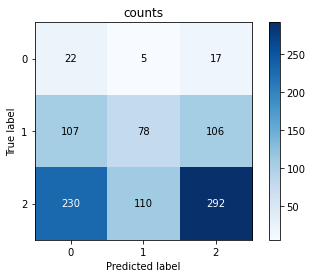

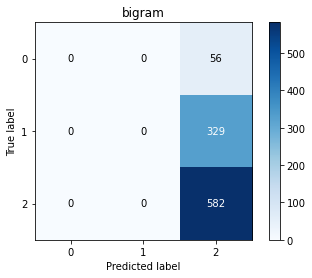

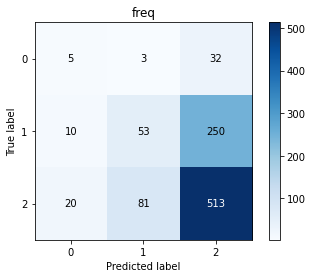

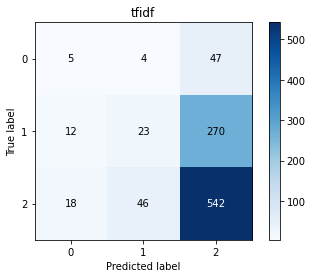

In [46]:


disp = plot_confusion_matrix(y_test_counts, y_pred_counts)
disp.set_title('counts')
disp = plot_confusion_matrix(y_test_bigram, y_pred_bigram)
disp.set_title('bigram')
disp = plot_confusion_matrix(y_test_freq, y_pred_freq)
disp.set_title('freq')
disp = plot_confusion_matrix(y_test_tfidf, y_pred_tfidf)
disp.set_title('tfidf')

plt.show()